In [1]:
from matplotlib import pyplot as plt
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.criteria import TargetClassProbability 
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

Using TensorFlow backend.


In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

# There's a lady who's sure, all that glitters is gold...

We have seen so far how the introduction of techniques such as convolution can improve the performance of our networks in quite a significant way. Thus, we might be tempted to say that our networks can solve the problem of object recognition well enough, at the small cost of some supervised training.

### **...is it true, though?**

Now we will analyze what happens when we add some noise to the image, and how the network reacts to its presence. We will use different kinds of noises, some (blurring, salt-and-pepper) more plausible than others (uniform, gaussian). For this tutorial we will make use of FoolBox, a toolbox developed in the lab of Prof. Mattias Bethge to put to test deep learning models.

In [3]:
# instantiate model
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

In [4]:
# get source image and label
image, label = foolbox.utils.imagenet_example()

#### Now, for a simple exercise...

Now, try to estimate how the probability of the correct class varies with the amount of noise applied to the image, for different kinds of noises. You can try any noise you want, but common choices are additive random noises (uniform, gaussian, etc...), gaussian blur, and salt-and-pepper. Plot how the probability of the correct class varies vs. the amount of noise you added.

In [5]:
# A couple of hints:
# 1) Remember: you can mix import statements and code
# 2) Take a look at the scipy.ndimage.filters module, it might have something that might
#    help you...

# P.S. remember to use preprocess_image on the input image before the ResNet models, and feed it a copy of image using image.copy()

In [6]:
def salt_pepper(img, prob):
    npix = np.rint(img.size*prob/3).astype(np.int32)
    idx = np.random.randint(0, img.size/3, npix)
    idx = np.unravel_index(idx, img.shape[0:2])
    local_img = img.copy()
    local_img[idx[0], idx[1], :] = np.tile(np.array([255, 255, 255]), (npix, 1))*np.random.randint(2, size=(npix, 1))
    
    return local_img

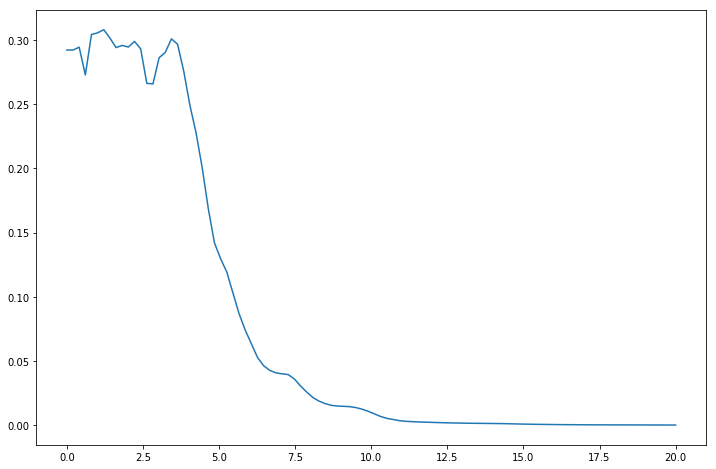

In [7]:
import scipy.ndimage.filters as filters

nsigma = 100
p_class_blur = np.zeros(nsigma)
sigma_val = np.linspace(0,20,nsigma)

for i in range(nsigma):
    img_blur = filters.gaussian_filter(image.copy(), sigma=(sigma_val[i], sigma_val[i], 0))
    img_blur = preprocess_input(img_blur[np.newaxis, :, :, :].copy())
    prob = kmodel.predict((img_blur))[0, :]
    p_class_blur[i] = prob[label]

plt.plot(sigma_val, p_class_blur)
plt.show()

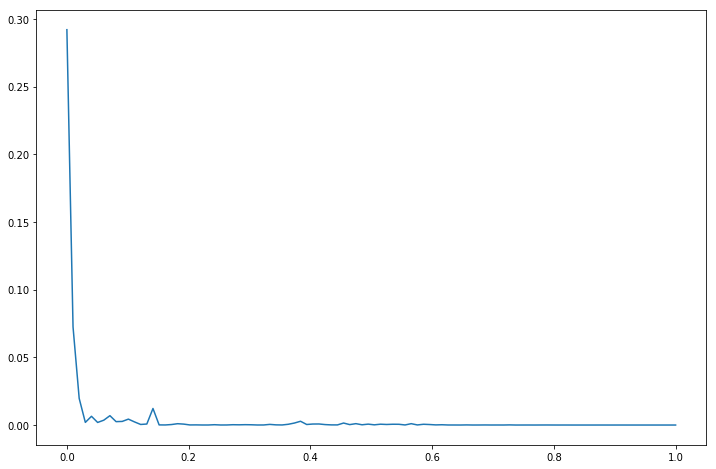

In [8]:
n_p = 100
p_class_salt_pepper = np.zeros(n_p)
p_val = np.linspace(0,1,n_p)

for i in range(n_p):
    img_blur = salt_pepper(image, p_val[i])
    img_blur = preprocess_input(img_blur[np.newaxis, :, :, :].copy())
    prob = kmodel.predict((img_blur))[0, :]
    p_class_salt_pepper[i] = prob[label]

plt.plot(p_val, p_class_salt_pepper)
plt.show()

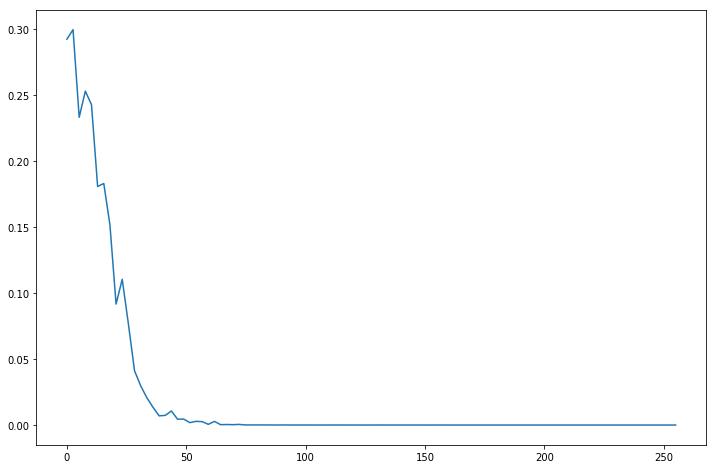

In [9]:
n_sigma = 100
p_class_gaussian = np.zeros(n_sigma)
sigma_val = np.linspace(0,255.0,n_sigma)

for i in range(n_sigma):
    img_blur = image.copy() + np.random.normal(scale=sigma_val[i], size=image.shape)
    img_blur[img_blur > 255.0] = 255.0
    img_blur[img_blur < 0.0] = 0.0
    img_blur = preprocess_input(img_blur[np.newaxis, :, :, :].copy())
    prob = kmodel.predict((img_blur))[0, :]
    p_class_gaussian[i] = prob[label]

plt.plot(sigma_val, p_class_gaussian)
plt.show()

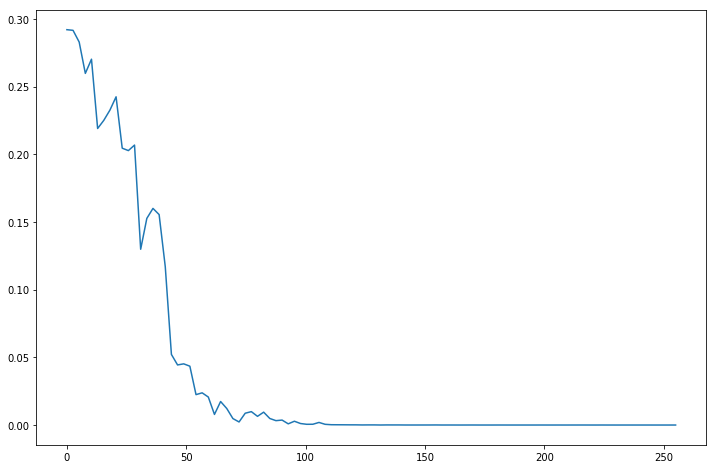

In [10]:
n_sigma = 100
p_class_uniform = np.zeros(n_sigma)
sigma_val = np.linspace(0,255.0,n_sigma)

for i in range(n_sigma):
    img_blur = image.copy() + np.random.uniform(low=-sigma_val[i], high=sigma_val[i], size=image.shape)
    img_blur[img_blur > 255.0] = 255.0
    img_blur[img_blur < 0.0] = 0.0
    img_blur = preprocess_input(img_blur[np.newaxis, :, :, :].copy())
    prob = kmodel.predict((img_blur[:, :, :, :]))[0, :]
    p_class_uniform[i] = prob[label]

plt.plot(sigma_val, p_class_uniform)
plt.show()

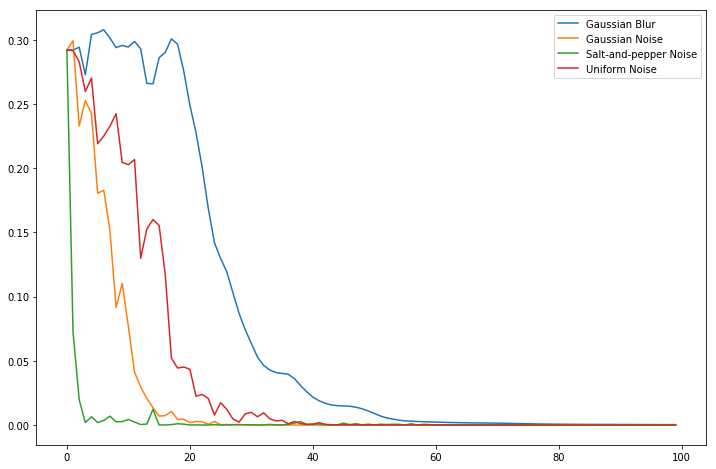

In [11]:
plt.plot(np.array([p_class_blur, p_class_gaussian, p_class_salt_pepper, p_class_uniform]).T)
plt.legend(["Gaussian Blur", "Gaussian Noise", "Salt-and-pepper Noise", "Uniform Noise"])
plt.show()

Top 5 predictions (adversarial):
n02119789, kit_fox, 0.14231057465076447
n02119022, red_fox, 0.130232572555542
n02123159, tiger_cat, 0.11041339486837387
n02123045, tabby, 0.0597243569791317
n02115913, dhole, 0.04746710881590843

Top 5 predictions (original):
n02123159, tiger_cat, 0.2921046316623688
n02123045, tabby, 0.2530863881111145
n02127052, lynx, 0.14645925164222717
n02124075, Egyptian_cat, 0.10347867757081985
n02119022, red_fox, 0.03192891180515289



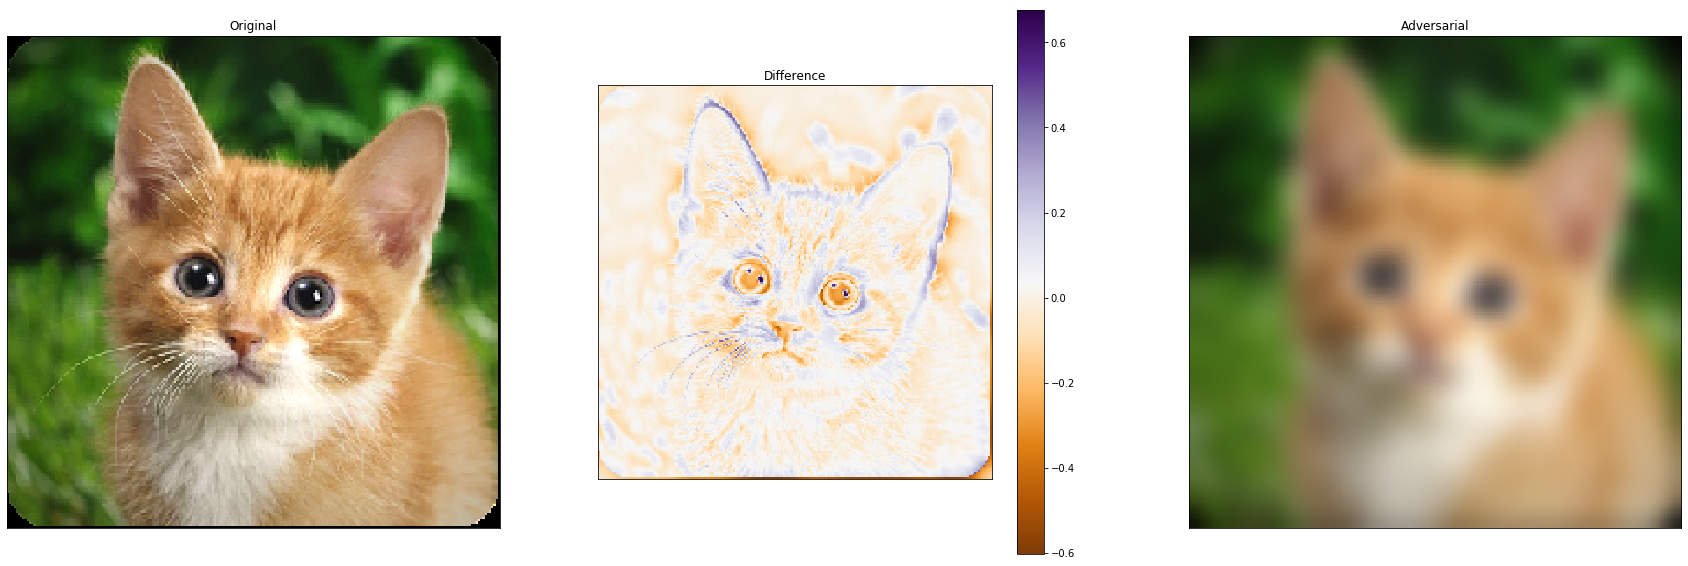

In [12]:
attack = foolbox.attacks.GaussianBlurAttack(model=fmodel)
adversarial = attack(image[:, :, ::-1], label)

# show results
adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
preds_orig = kmodel.predict(preprocess_input(image[np.newaxis, :, :, :].copy()))
decoded_preds = decode_predictions(preds, top=5)[0]
decoded_preds_orig = decode_predictions(preds_orig, top=5)[0]
print("Top 5 predictions (adversarial):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds]))
print("Top 5 predictions (original):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds_orig]))


[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image, np.mean(image - adversarial[:, :, ::-1], axis=2), adversarial[:, :, ::-1])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if imdata.ndim == 2:
        im = axis.imshow(imdata/255.0, cmap='PuOr')
        figure.colorbar(im, cmap='PuOr', ax=axis)
    else:
        axis.imshow(imdata/255.0)
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

Top 5 predictions (adversarial):
n02123045, tabby, 0.28941822052001953
n02123159, tiger_cat, 0.2842545807361603
n02127052, lynx, 0.12388543784618378
n02124075, Egyptian_cat, 0.10429475456476212
n02123597, Siamese_cat, 0.031172357499599457

Top 5 predictions (original):
n02123159, tiger_cat, 0.2921046316623688
n02123045, tabby, 0.2530863881111145
n02127052, lynx, 0.14645925164222717
n02124075, Egyptian_cat, 0.10347867757081985
n02119022, red_fox, 0.03192891180515289



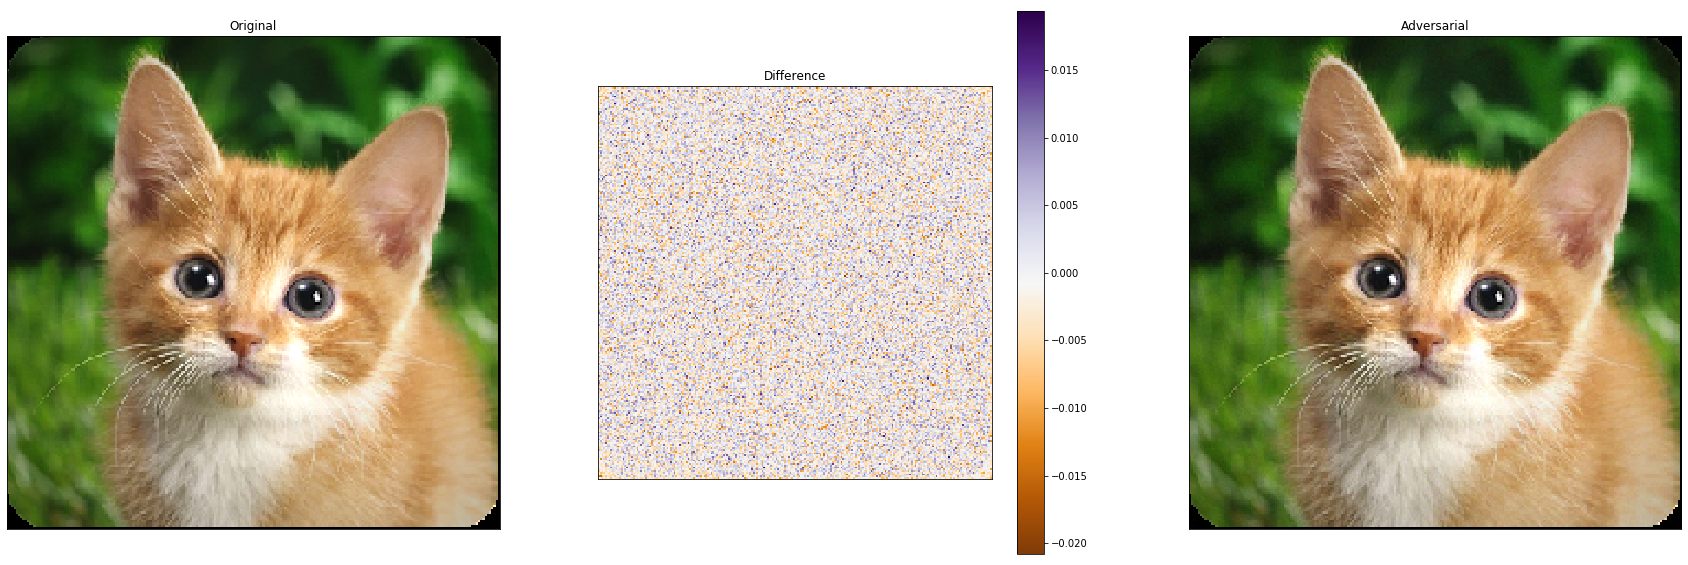

In [13]:
attack = foolbox.attacks.AdditiveGaussianNoiseAttack(model=fmodel)
adversarial = attack(image[:, :, ::-1], label)

# show results
adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
preds_orig = kmodel.predict(preprocess_input(image[np.newaxis, :, :, :].copy()))
decoded_preds = decode_predictions(preds, top=5)[0]
decoded_preds_orig = decode_predictions(preds_orig, top=5)[0]
print("Top 5 predictions (adversarial):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds]))
print("Top 5 predictions (original):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds_orig]))

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image, np.mean(image - adversarial[:, :, ::-1], axis=2), adversarial[:, :, ::-1])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if imdata.ndim == 2:
        im = axis.imshow(imdata/255.0, cmap='PuOr')
        figure.colorbar(im, cmap='PuOr', ax=axis)
    else:
        axis.imshow(imdata/255.0)
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

Top 5 predictions (adversarial):
n02123045, tabby, 0.26340940594673157
n02123159, tiger_cat, 0.24566276371479034
n02127052, lynx, 0.15769581496715546
n02124075, Egyptian_cat, 0.10390812158584595
n02119022, red_fox, 0.04279638081789017

Top 5 predictions (original):
n02123159, tiger_cat, 0.2921046316623688
n02123045, tabby, 0.2530863881111145
n02127052, lynx, 0.14645925164222717
n02124075, Egyptian_cat, 0.10347867757081985
n02119022, red_fox, 0.03192891180515289



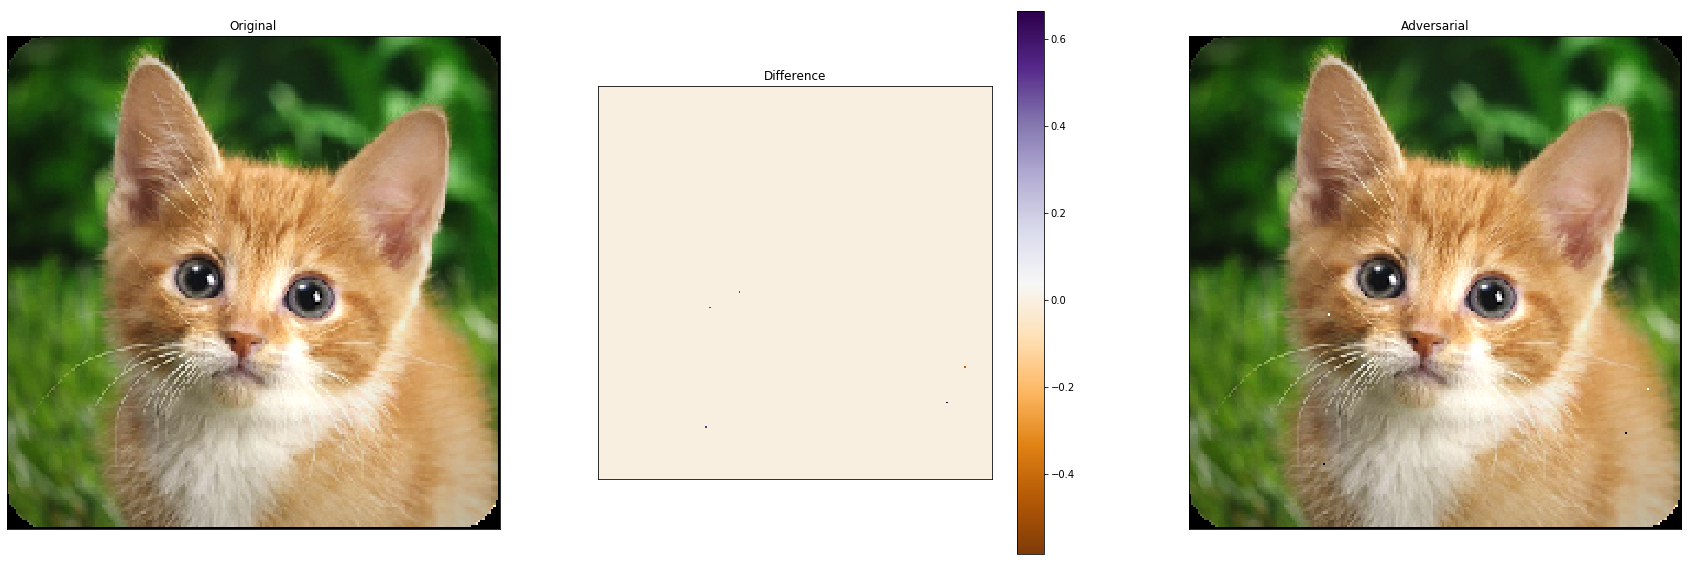

In [14]:
attack = foolbox.attacks.SaltAndPepperNoiseAttack(model=fmodel)
adversarial = attack(image[:, :, ::-1], label)

# show results
adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
preds_orig = kmodel.predict(preprocess_input(image[np.newaxis, :, :, :].copy()))
decoded_preds = decode_predictions(preds, top=5)[0]
decoded_preds_orig = decode_predictions(preds_orig, top=5)[0]
print("Top 5 predictions (adversarial):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds]))
print("Top 5 predictions (original):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds_orig]))

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image, np.mean(image - adversarial[:, :, ::-1], axis=2), adversarial[:, :, ::-1])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if imdata.ndim == 2:
        im = axis.imshow(imdata/255.0, cmap='PuOr')
        figure.colorbar(im, cmap='PuOr', ax=axis)
    else:
        axis.imshow(imdata/255.0)
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

# ...and she's buying a stairway to heaven.

So far the situation doesn't look particularly good for deep networks, even though the images are misclassified in classes that are quite related to the original class (e.g. "tabby" and "tiger cat").
There is, however, an intriguing property of deep networks: images can be perturbed in imperceptible ways that still cause the net to misclassify the input. The method we used is called the Fast Gradient Sign Method
$$
\eta=\epsilon\cdot\mathrm{sign}(\nabla_x C(\theta, x, y))
$$
This amounts to linearizing the cost function around the value of $\theta$ and then perturbing the image by adding a small amount in the direction pointed by the gradient; the adversarial is still classified in a category close to the original, but the perturbation is around $0.15‰$. If we allow the perturbation to be in the order of a few percent, we can also use an optimization method, such as the Limited-memory Broyden-Fletcher-Goldfarb-Shanno (a.k.a. L-BFGS) algorithm, to have the network misclassify the input in a category of choice.

In [15]:
# apply attack on source image
# ::-1 reverses the color channels, because Keras ResNet50
# expects BGR instead of RGB
attack = foolbox.attacks.FGSM(fmodel)
fg_adversarial = attack(image[:, :, ::-1], label)
# if the attack fails, adversarial will be None and a warning will be printed

Top 5 predictions (adversarial):
n02123045, tabby, 0.24686755239963531
n02123159, tiger_cat, 0.23162879049777985
n02127052, lynx, 0.17119677364826202
n02124075, Egyptian_cat, 0.10422122478485107
n02119022, red_fox, 0.04537777230143547

Top 5 predictions (original):
n02123159, tiger_cat, 0.2921046316623688
n02123045, tabby, 0.2530863881111145
n02127052, lynx, 0.14645925164222717
n02124075, Egyptian_cat, 0.10347867757081985
n02119022, red_fox, 0.03192891180515289



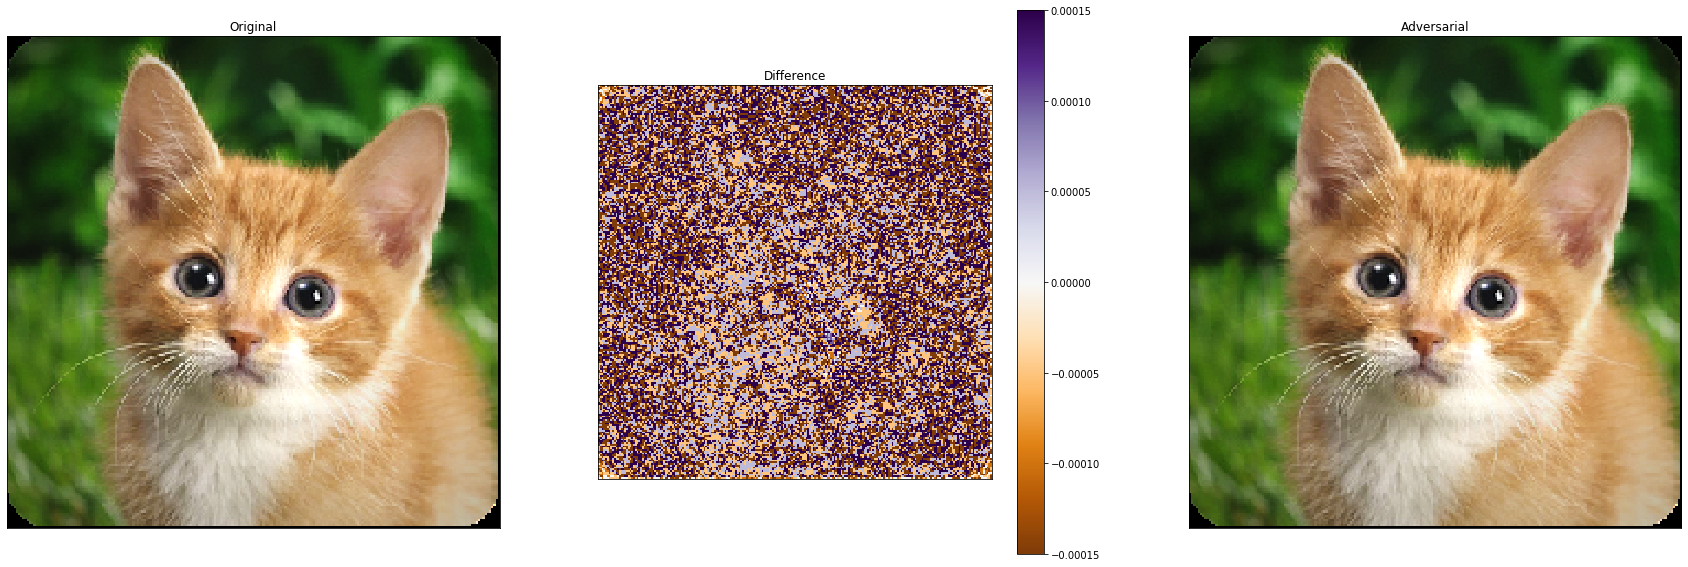

In [16]:
adversarial_rgb = fg_adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
preds_orig = kmodel.predict(preprocess_input(image[np.newaxis, :, :, :].copy()))
decoded_preds = decode_predictions(preds, top=5)[0]
decoded_preds_orig = decode_predictions(preds_orig, top=5)[0]
print("Top 5 predictions (adversarial):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds]))
print("Top 5 predictions (original):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds_orig]))

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image, np.mean(image - fg_adversarial[:, :, ::-1], axis=2), fg_adversarial[:, :, ::-1])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if imdata.ndim == 2:
        im = axis.imshow(imdata/255.0, cmap='PuOr')
        figure.colorbar(im, cmap='PuOr', ax=axis)
    else:
        axis.imshow(imdata/255.0)
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

In [17]:
# run the attack
target_class = 420
attack = LBFGSAttack(model=fmodel,
                     criterion=TargetClassProbability(target_class, p=.99))
lbfgs_adversarial = attack(image[:, :, ::-1], label)

# show results
print(np.argmax(fmodel.predictions(lbfgs_adversarial)))
print(foolbox.utils.softmax(fmodel.predictions(adversarial))[target_class])
adversarial_rgb = lbfgs_adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
preds_orig = kmodel.predict(preprocess_input(image[np.newaxis, :, :, :].copy()))
decoded_preds = decode_predictions(preds, top=5)[0]
decoded_preds_orig = decode_predictions(preds_orig, top=5)[0]
print("Top 5 predictions (adversarial):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds]))
print("Top 5 predictions (original):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds_orig]))

420
3.0507206e-05
Top 5 predictions (adversarial):
n02787622, banjo, 0.9899227023124695
n02123045, tabby, 0.001259198528714478
n02676566, acoustic_guitar, 0.001102495938539505
n03272010, electric_guitar, 0.0009463882306590676
n02123159, tiger_cat, 0.0009235232719220221

Top 5 predictions (original):
n02123159, tiger_cat, 0.2921046316623688
n02123045, tabby, 0.2530863881111145
n02127052, lynx, 0.14645925164222717
n02124075, Egyptian_cat, 0.10347867757081985
n02119022, red_fox, 0.03192891180515289



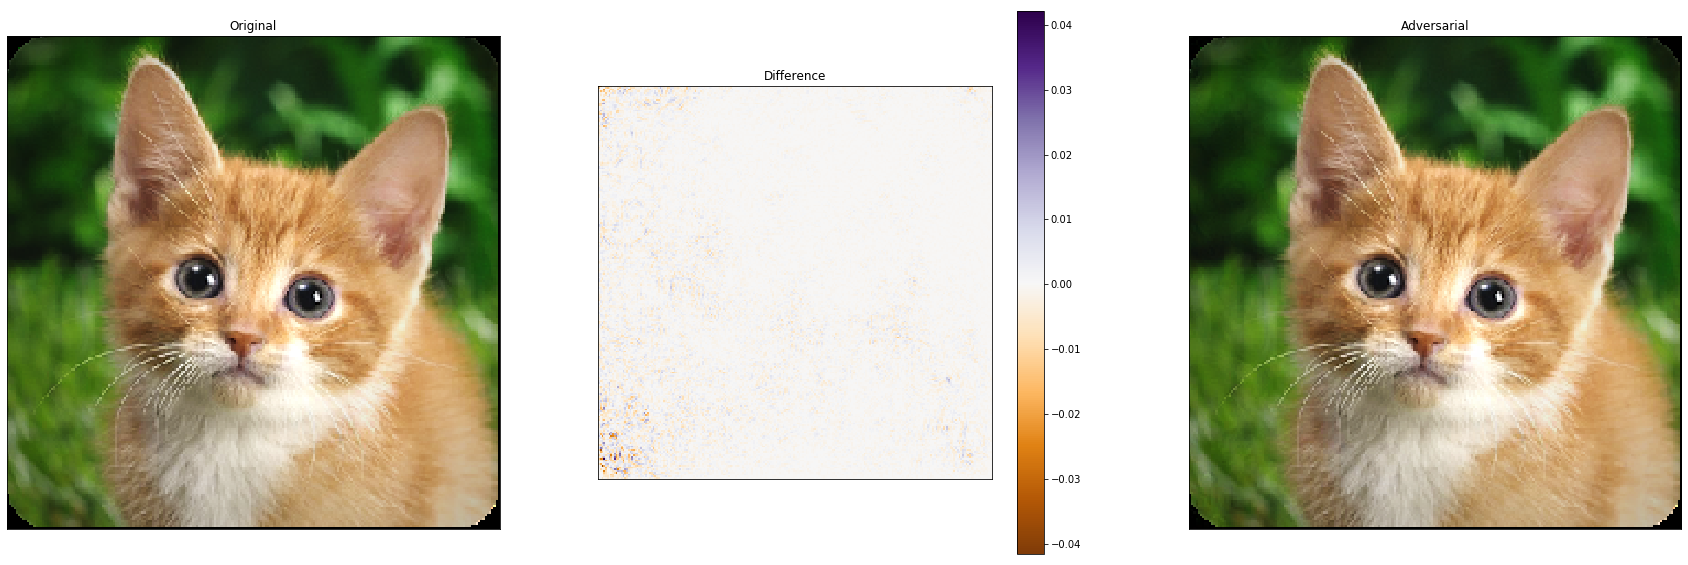

In [18]:
[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image, np.mean(image - lbfgs_adversarial[:, :, ::-1], axis=2), lbfgs_adversarial[:, :, ::-1])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if imdata.ndim == 2:
        im = axis.imshow(imdata/255.0, cmap='PuOr')
        figure.colorbar(im, cmap='PuOr', ax=axis)
    else:
        axis.imshow(imdata/255.0)
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

In [19]:
keras.backend.clear_session()
import keras.applications.mobilenet as mobilenet
model = mobilenet.MobileNet()
keras.backend.set_learning_phase(0)

adversarial_rgb = lbfgs_adversarial[np.newaxis, :, :, ::-1]
preds = model.predict(mobilenet.preprocess_input(adversarial_rgb.copy()))
preds_orig = model.predict(mobilenet.preprocess_input(image.copy()[np.newaxis, :, :, :]))
decoded_preds = mobilenet.decode_predictions(preds, top=5)[0]
decoded_preds_orig = mobilenet.decode_predictions(preds_orig, top=5)[0]
print("Top 5 predictions (adversarial):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds]))
print("Top 5 predictions (original):\n" +
      "".join(["{}, {}, {}\n".format(*i) for i in decoded_preds_orig]))

Top 5 predictions (adversarial):
n02123159, tiger_cat, 0.39885157346725464
n02123045, tabby, 0.39743340015411377
n02127052, lynx, 0.07897242158651352
n02909870, bucket, 0.016742227599024773
n02123394, Persian_cat, 0.013172919861972332

Top 5 predictions (original):
n02123159, tiger_cat, 0.3927823305130005
n02123045, tabby, 0.36469924449920654
n02127052, lynx, 0.10599182546138763
n02124075, Egyptian_cat, 0.015602084808051586
n02909870, bucket, 0.014985686168074608



In [20]:
(i_train, l_train), (i_test, l_test) = keras.datasets.mnist.load_data()
i_train, i_test = i_train/255.0, i_test/255.0
i_train, i_test = i_train.astype(np.float32), i_test.astype(np.float32)
i_train, i_test = np.expand_dims(i_train, 3), np.expand_dims(i_test, 3)
l_train, l_test = keras.utils.np_utils.to_categorical(l_train), keras.utils.np_utils.to_categorical(l_test)
i_validate = i_train[50000:, :, :, :]
i_train = i_train[0:50000, :, :, :]
l_validate = l_train[50000:, :]
l_train = l_train[0:50000, :]

In [21]:
kmodel = keras.models.load_model('models/convolutional_2dense.h5')
fmodel = KerasModel(kmodel, bounds=(0,1))

Label predicted: 5, true label: 0


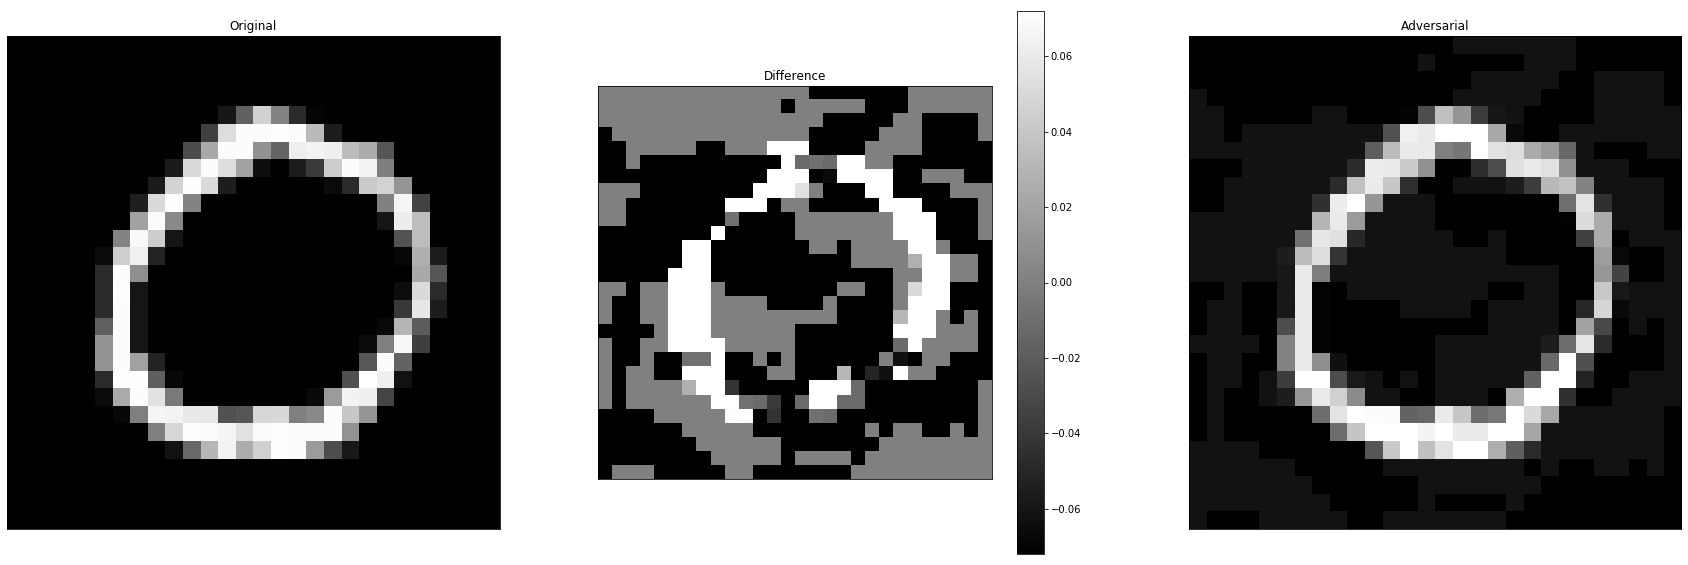

In [22]:
image = i_validate[42]
label = np.argmax(l_validate[42])
attack = foolbox.attacks.FGSM(model=fmodel)
adversarial_fg = attack(image, label)
adversarial = adversarial_fg

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image[:, :, 0], (image[:, :, 0] - adversarial[:, :, 0]), adversarial[:, :, 0])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if title == "Difference":
        im = axis.imshow(imdata, cmap='gray')
        figure.colorbar(im, cmap='gray', ax=axis)
    else:
        axis.imshow(imdata, cmap='gray')
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
    
print("Label predicted: %d, true label: %d" %
      (np.argmax(fmodel.predictions(adversarial)),
       np.argmax(fmodel.predictions(image))))

Label predicted: 5, true label: 7


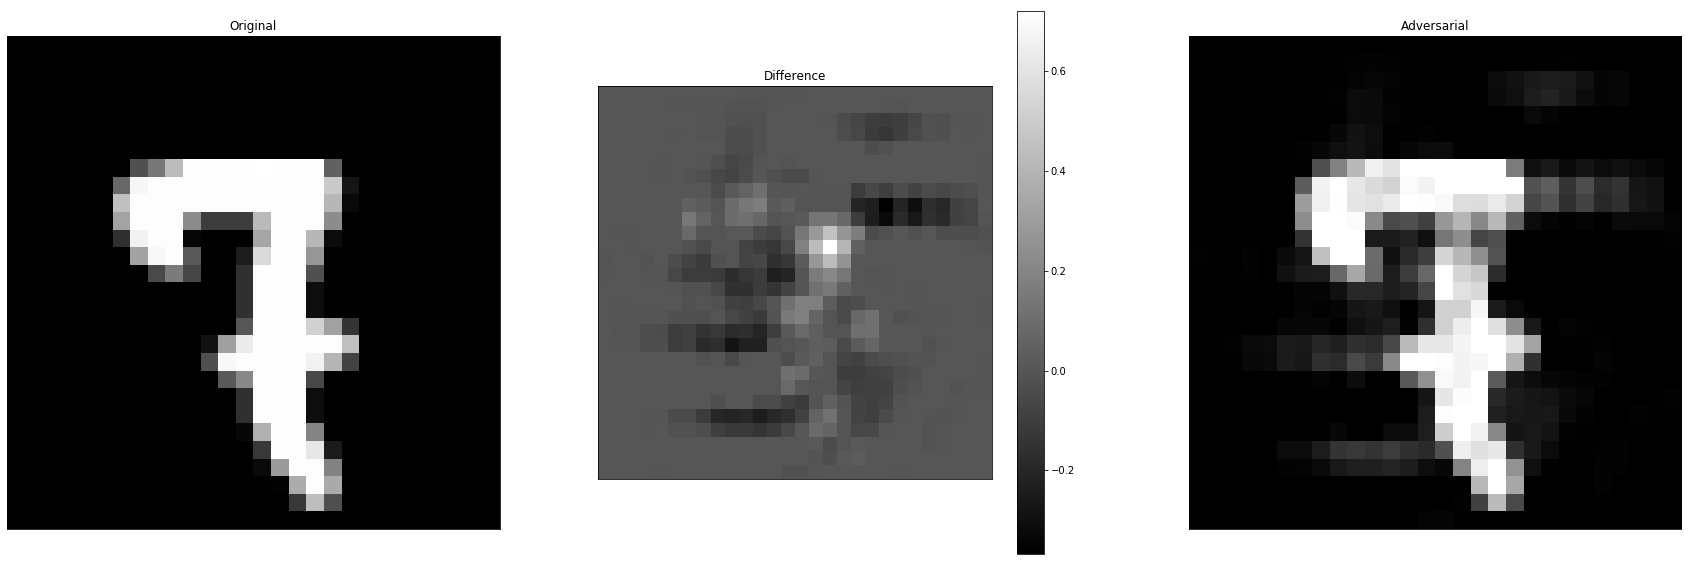

In [23]:
source_class = 64
image = i_validate[source_class]
label = np.argmax(l_validate[source_class])
target_class = 5
attack = LBFGSAttack(model=fmodel,
                     criterion=TargetClassProbability(target_class, p=.5))
adversarial_lbfgs = attack(image, label)
adversarial = adversarial_lbfgs

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image[:, :, 0], (image[:, :, 0] - adversarial[:, :, 0]), adversarial[:, :, 0])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if title == "Difference":
        im = axis.imshow(imdata, cmap='gray')
        figure.colorbar(im, cmap='gray', ax=axis)
    else:
        axis.imshow(imdata, cmap='gray')
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
    
print("Label predicted: %d, true label: %d" %
      (np.argmax(fmodel.predictions(adversarial)),
       np.argmax(fmodel.predictions(image))))

In [24]:
kmodel = keras.models.load_model('models/convolutional_dropout.h5')

adversarial = adversarial_lbfgs

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image[:, :, 0], (image[:, :, 0] - adversarial[:, :, 0]), adversarial[:, :, 0])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if title == "Difference":
        im = axis.imshow(imdata, cmap='gray')
        figure.colorbar(im, cmap='gray', ax=axis)
    else:
        axis.imshow(imdata, cmap='gray')
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
    
print("Label predicted: %d, true label: %d" %
      (np.argmax(fmodel.predictions(adversarial)),
       np.argmax(fmodel.predictions(image))))

OSError: Unable to open file (unable to open file: name = 'models/convolutional_dropout.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)